In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

!nvidia-smi

Sun Jul 14 16:10:55 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 37%   24C    P8    28W / 350W |      6MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:23:00.0 Off |                  N/A |
| 37%   

### Stable Diffusion Load

In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDPMScheduler

device = 'cuda:0'

# pipe = StableDiffusionPipeline.from_single_file("/data/sd_files/stable-diffusion-v1-5/v1-5-pruned.safetensors",
#                                                torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

pipe = StableDiffusionPipeline.from_single_file("/data/sd_files/checkpoint/beautifulRealistic_v7.safetensors",
                                               torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

pipe.to(device)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

print('done')

/home/gaudio/anaconda3/envs/lsd/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gaudio/anaconda3/envs/lsd/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gaudio/anaconda3/envs/lsd/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


done


### Pipeline의 구성 보기

In [3]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.25.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Tokenizer & TextEncoder

In [4]:
# pipeline에서 tokenizer와 text_encoder 가져오기
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

In [5]:
# tokenizer 정보 보기
tokenizer

CLIPTokenizer(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [6]:
# text encoder 정보 보기
text_encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [7]:
# 프롬프트 설정
prompt = "(K-pop idol), 1girl, masterpiece, 8k, ultra high resolution, ultra high detail, ultra high quality, photo-realistic, focus, contrast, detailed lighting, subsurface scattering, reflections, depth, ultra realistic skin, utlra detailed beautiful eyes, supple lips, South Korea, detailed background, outside, nighttime, raining, narrow alleyway, neon lights, (half body photo), moist skin, candid, <lora:add_detail:1>,"

# 토크나이저로 프롬프트 인코딩
# https://github.com/huggingface/diffusers/blob/v0.29.1/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py
# line. 366-372
text_inputs = tokenizer(prompt,
                   padding="max_length",
                   max_length=tokenizer.model_max_length,
                   truncation=True,
                   return_tensors="pt").to(device)
text_inputs

{'input_ids': tensor([[49406,   263,   330,   268,  2852,  8884,  2361,   272,  1611,   267,
         12066,   267,   279,   330,   267,  8118,  1400,  9977,   267,  8118,
          1400,  7657,   267,  8118,  1400,  3027,   267,  1125,   268, 16157,
           267,  4353,   267, 18501,   267, 12609,  5799,   267,  1783,  7744,
         13899,  7929,   267, 16647,   267, 10350,   267,  8118, 16157,  3575,
           267,  1419,    75,  1735, 12609,  1215,  3095,   267,  1023,   579,
          8847,   267,  2045,  5915,   267, 12609,  5994,   267,  2782,   267,
         38147,   267, 13964,   267, 16652, 36205, 49407]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]], device='cuda:0')}

In [8]:
# 각 토큰에 대응하는 단어 출력
tokens = text_inputs.input_ids[0]
tokens_str = [tokenizer.decode([token]) for token in tokens]

# 텍스트와 대응하는 토큰 출력
for i, (id, token) in enumerate(zip(text_inputs.input_ids[0], tokens_str)):
    print(f"Token {id}: {token}")


Token 49406: <|startoftext|>
Token 263: (
Token 330: k
Token 268: -
Token 2852: pop
Token 8884: idol
Token 2361: ),
Token 272: 1
Token 1611: girl
Token 267: ,
Token 12066: masterpiece
Token 267: ,
Token 279: 8
Token 330: k
Token 267: ,
Token 8118: ultra
Token 1400: high
Token 9977: resolution
Token 267: ,
Token 8118: ultra
Token 1400: high
Token 7657: detail
Token 267: ,
Token 8118: ultra
Token 1400: high
Token 3027: quality
Token 267: ,
Token 1125: photo
Token 268: -
Token 16157: realistic
Token 267: ,
Token 4353: focus
Token 267: ,
Token 18501: contrast
Token 267: ,
Token 12609: detailed
Token 5799: lighting
Token 267: ,
Token 1783: sub
Token 7744: surface
Token 13899: scat
Token 7929: tering
Token 267: ,
Token 16647: reflections
Token 267: ,
Token 10350: depth
Token 267: ,
Token 8118: ultra
Token 16157: realistic
Token 3575: skin
Token 267: ,
Token 1419: ut
Token 75: l
Token 1735: ra
Token 12609: detailed
Token 1215: beautiful
Token 3095: eyes
Token 267: ,
Token 1023: supp
Token 579

In [9]:
# 텍스트 인코더로 인코딩된 입력을 통해 잠재 표현(embeddings) 추출
text_input_ids = text_inputs.input_ids.to(device)
attention_mask = text_inputs.attention_mask.to(device)

with torch.no_grad():
    prompt_embeds = text_encoder(text_input_ids,
                                 attention_mask=attention_mask,
                                 output_hidden_states=True
                )
    prompt_embeds = prompt_embeds[0]
    
print(prompt_embeds.shape)
prompt_embeds

torch.Size([1, 77, 768])


tensor([[[-0.3545,  0.0036, -0.0704,  ..., -0.4519, -0.2944,  0.0677],
         [ 0.4639, -1.4297,  0.2380,  ..., -1.2080,  1.9043, -0.1930],
         [ 0.4951, -1.0254, -0.3215,  ..., -0.8384, -0.1289,  0.0115],
         ...,
         [-0.0995, -0.9170,  1.3154,  ..., -0.1367, -0.7563, -0.7876],
         [ 0.4580, -0.6172,  1.3867,  ..., -0.1665, -1.1582, -0.7373],
         [ 0.2244, -0.8853,  1.0127,  ...,  0.1915, -1.5488, -0.1338]]],
       device='cuda:0', dtype=torch.float16)

In [10]:
n_prompt = "low quality, low resolution, worst quality, low quality, normal quality, lowres, normal quality, signature, watermark, jpeg artifacts, service mark, trademark, distorted, pixelated, blurry, cropped, cut off, split image, tiling, trimmed, bad illustration, bad composition, bad proportions, incorrect ratio, improper scale, blank background, boring background, bad anatomy, wrong anatomy, incorrect physiology, amputee, deformed, disfigured, dismembered, disproportional, duplicate, duplicated features, extra arms, extra fingers, extra hands, extra legs, extra limbs, fault, flaw, fused fingers, gross proportions, malformed, misshapen, missing arms, missing fingers, missing hands, missing legs, cross-eyed, bad hands, bad feet, bad eyes, mistake, obese, fat, mutated hands, mutation, mutilated, poorly drawn body, poorly drawn face, poorly drawn hands, ugly, unfocused, unattractive, monochrome, grayscale, ng_deepnegative_v1_75t, badhandv4, earrings, earring,"
n_text_inputs = tokenizer(n_prompt,
                   padding="max_length",
                   max_length=tokenizer.model_max_length,
                   truncation=True,
                   return_tensors="pt").to(device)
n_text_inputs

{'input_ids': tensor([[49406,  1042,  3027,   267,  1042,  9977,   267,  5719,  3027,   267,
          1042,  3027,   267,  5967,  3027,   267,  1049,   934,   267,  5967,
          3027,   267,  9189,   267,  2505,  2110,   267,    73, 11207, 30249,
           267,  2086,  2110,   267, 25011,   267, 23781,   775,   267, 14384,
           943,   267, 21977,   267, 31139,   267,  3032,  1007,   267,  9109,
          2867,   267,    83,  3299,   267, 40657,   267,  2103,  6052,   267,
          2103, 17510,   267,  2103, 39391,   267, 31872, 15893,   267,  2531,
          1284,  5879,   267, 15134,  5994,   267, 49407]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]], device='cuda:0')}

In [11]:
with torch.no_grad():
    negative_prompt_embeds = text_encoder(n_text_inputs.input_ids.to(device),
                                 attention_mask=attention_mask,
                                 output_hidden_states=True
                )
    negative_prompt_embeds = negative_prompt_embeds[0]
    
print(negative_prompt_embeds.shape)
negative_prompt_embeds

torch.Size([1, 77, 768])


tensor([[[-0.3545,  0.0036, -0.0704,  ..., -0.4519, -0.2944,  0.0677],
         [-0.4849, -1.4307,  1.0010,  ..., -0.1438,  0.3286,  0.1816],
         [ 0.5093, -0.7061,  2.6309,  ..., -1.3740, -1.0332,  0.9487],
         ...,
         [ 1.1748,  0.6699,  0.2803,  ..., -0.9907, -0.6108,  0.3545],
         [ 0.8159, -1.3916, -0.3320,  ..., -0.7217, -0.7163, -0.7100],
         [ 0.3418, -1.2549,  0.1772,  ..., -0.4819,  0.0392, -0.0258]]],
       device='cuda:0', dtype=torch.float16)

In [12]:
# # line 946
prompt_concat_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
print(prompt_concat_embeds.shape)
prompt_concat_embeds

torch.Size([2, 77, 768])


tensor([[[-0.3545,  0.0036, -0.0704,  ..., -0.4519, -0.2944,  0.0677],
         [-0.4849, -1.4307,  1.0010,  ..., -0.1438,  0.3286,  0.1816],
         [ 0.5093, -0.7061,  2.6309,  ..., -1.3740, -1.0332,  0.9487],
         ...,
         [ 1.1748,  0.6699,  0.2803,  ..., -0.9907, -0.6108,  0.3545],
         [ 0.8159, -1.3916, -0.3320,  ..., -0.7217, -0.7163, -0.7100],
         [ 0.3418, -1.2549,  0.1772,  ..., -0.4819,  0.0392, -0.0258]],

        [[-0.3545,  0.0036, -0.0704,  ..., -0.4519, -0.2944,  0.0677],
         [ 0.4639, -1.4297,  0.2380,  ..., -1.2080,  1.9043, -0.1930],
         [ 0.4951, -1.0254, -0.3215,  ..., -0.8384, -0.1289,  0.0115],
         ...,
         [-0.0995, -0.9170,  1.3154,  ..., -0.1367, -0.7563, -0.7876],
         [ 0.4580, -0.6172,  1.3867,  ..., -0.1665, -1.1582, -0.7373],
         [ 0.2244, -0.8853,  1.0127,  ...,  0.1915, -1.5488, -0.1338]]],
       device='cuda:0', dtype=torch.float16)

### Unet & Scheduler

In [14]:
unet = pipe.unet
scheduler = pipe.scheduler

In [15]:
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [16]:
scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.25.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [17]:
# Init. random noise
height, width = 512, 512
latents = torch.randn((1, unet.config.in_channels, height//8, width//8)).half().to(device)
print(latents.shape)

scheduler.set_timesteps(20)

torch.Size([1, 4, 64, 64])


In [18]:
from tqdm import tqdm

with torch.no_grad():    
    # Sampling
    guidance_scale = 7.0
    for t in tqdm(scheduler.timesteps):
        # Latent와 텍스트 임베딩을 사용하여 노이즈 예측
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        noise_pred = unet(latent_model_input,
                          t,
                          encoder_hidden_states=prompt_concat_embeds,
                          return_dict=False
                         )[0]
        
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Scheduler를 사용하여 latents 업데이트
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 25.51it/s]


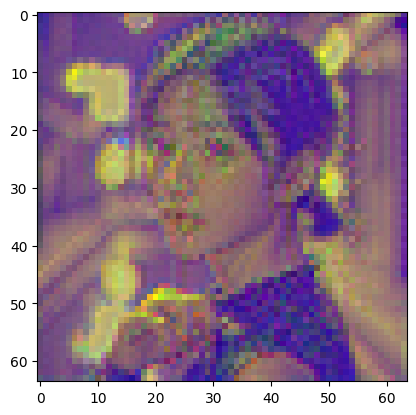

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

_latents = latents[0, :3].permute(1, 2, 0).cpu().numpy().astype(np.float32)
_latents = (_latents - _latents.min()) / (_latents.max() - _latents.min())
plt.imshow(_latents)
plt.show()

### VAE Decoder

In [20]:
vae = pipe.vae
vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

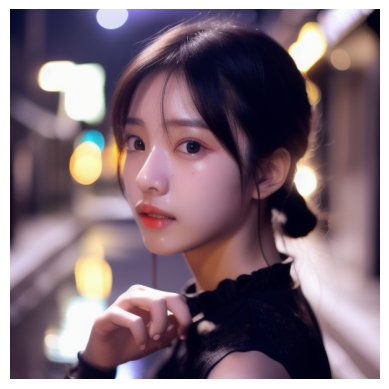

In [21]:
with torch.no_grad():
    images = vae.decode(latents / vae.config.scaling_factor, return_dict=False)[0]
    
# 이미지를 [0, 1] 범위로 스케일링
images = (images / 2 + 0.5).clamp(0, 1)

# 이미지를 CPU로 이동하고 numpy 배열로 변환
images = images.cpu().permute(0, 2, 3, 1).numpy()

# 이미지 출력
import matplotlib.pyplot as plt

plt.imshow(images[0].astype(np.float32))
plt.axis("off")
plt.show()